In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import xgboost

from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from scipy.sparse import hstack

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

In [92]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [93]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [94]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [95]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [96]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [97]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(solver='lbfgs', random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867416154689059+-0.00858489536400079


Посчитаем precision/recall/f_score

In [98]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
lr_result = [thresholds[ix], fscore[ix], precision[ix], recall[ix]]

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

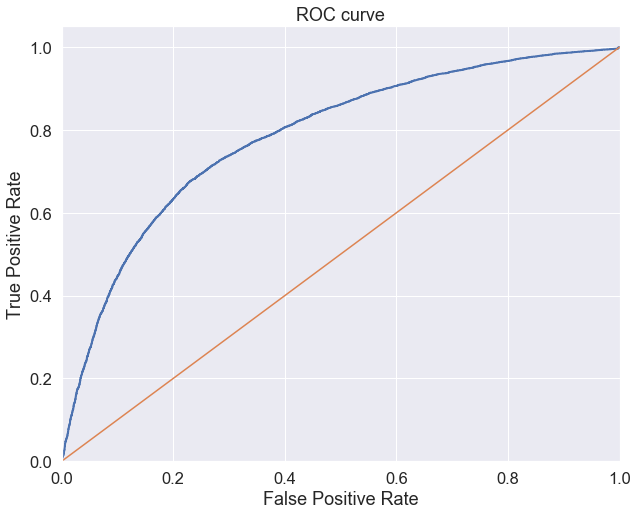

In [99]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


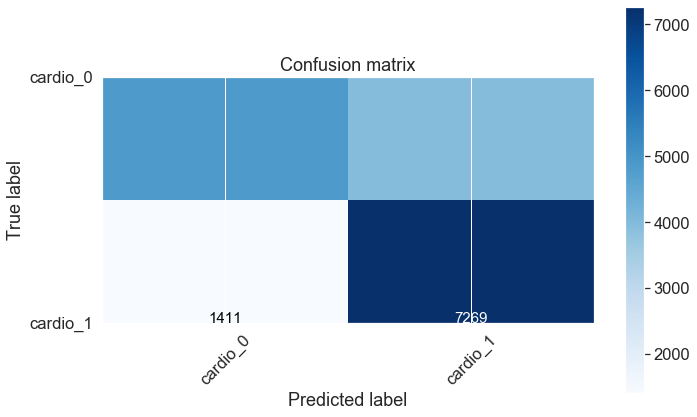

In [100]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [101]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

In [102]:
xg_classifier = Pipeline([
    ('features',feats),
    ('classifier', xgboost.XGBClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(xg_classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
xg_classifier.fit(X_train, y_train)
y_score = xg_classifier.predict_proba(X_test)[:, 1]

CV score is 0.7976942419864884+-0.007336577733265078


In [103]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
xg_result=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]

Best Threshold=0.347103, F-Score=0.738, Precision=0.665, Recall=0.828


In [104]:
xg_cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
xg_cnf_matrix

array([[5202, 3618],
       [1491, 7189]])

In [105]:
rfc_classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state = 42)),
]) #количество деревьев добавлено для удаления сообщения о будущей ошибки.


#запустим кросс-валидацию
cv_scores = cross_val_score(rfc_classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
rfc_classifier.fit(X_train, y_train)
y_score = rfc_classifier.predict_proba(X_test)[:, 1]

CV score is 0.7740984217534101+-0.0074866662533876254


In [106]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
rfc_result=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]

Best Threshold=0.350000, F-Score=0.719, Precision=0.643, Recall=0.816


In [118]:
rf_cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
rf_cnf_matrix

array([[4991, 3829],
       [1663, 7017]])

In [119]:
rows = ['thresholds', 'f_score', 'prec', 'rec']
cols = ['lr_model', 'xg_boost model', 'rf_model']

res = pd.DataFrame([lr_result, xg_result, rfc_result], cols, rows)

In [120]:
res

,thresholds,f_score,prec,rec
lr_model,0.386937,0.730323,0.647431,0.837558
xg_boost model,0.347103,0.737890,0.665248,0.828341
rf_model,0.350000,0.718863,0.642669,0.815553


In [121]:
cnf_matrix

array([[4861, 3959],
       [1411, 7269]])

In [122]:
xg_cnf_matrix 

array([[5202, 3618],
       [1491, 7189]])

In [123]:
rf_cnf_matrix

array([[4991, 3829],
       [1663, 7017]])

Без дополнительных настроек и обработки датасета лучше отработал xg_boost так как его точность выше почти на 2 процента относительно линейной регрессии при падении полноты менее чем на процент. 

Первая модель будет лучше, так как она точнее определяет верно целевой класс при этом ошибочно помечает меньшее количество объектов, соответственно при дисбалансе классов лучше использовать precision_recall_curve.

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic